In [1]:
import os
from collections import Counter
from multiprocessing import Pool

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import tldextract

In [2]:
def count_email_providers(shard):
    c = Counter()
    for email_address in shard:
        c.update({tldextract.extract(email_address).fqdn: 1})
    return c


def count_creation_times(shard):
    c = Counter()
    for creation_time in shard:
        c.update({creation_time: 1})
    return c

In [3]:
# Note: Actual filename of data dump has been redacted in this repository
# Use 7zip to extract Twitter 200M data dump dataset ("filename_redacted.7z") to "filename_redacted.txt" before continuing
filename = "filename_redacted.txt"
df = pl.read_csv(filename, columns=["Email", "Created At"])
print("{:,}".format(len(df)), "records")

with Pool(os.cpu_count()) as pool:
    accounts_per_shard = 500_000

    email_provider_counts_sharded = pool.map(
        count_email_providers,
        (
            df["Email"][i : i + accounts_per_shard]
            for i in range(0, len(df), accounts_per_shard)
        ),
    )
    email_provider_counts = Counter()
    for c in email_provider_counts_sharded:
        email_provider_counts.update(c)

    creation_time_counts_sharded = pool.map(
        count_creation_times,
        (
            df["Created At"][i : i + accounts_per_shard]
            for i in range(0, len(df), accounts_per_shard)
        ),
    )
    creation_time_counts = Counter()
    for c in creation_time_counts_sharded:
        creation_time_counts.update(c)

209,595,667 records


In [4]:
email_provider_stats = pl.DataFrame(
    list(email_provider_counts.items()), columns=["Email Provider", "Number of Users"]
).sort(["Number of Users", "Email Provider"], reverse=True)

print("Email providers with at least 1 million users in Twitter 200M data dump")
filtered = email_provider_stats.filter(pl.col("Number of Users") >= 1e6)
pl.Config.set_tbl_rows(100)
print(filtered)

Email providers with at least 1 million users in Twitter 200M data dump
shape: (15, 2)
┌────────────────┬─────────────────┐
│ Email Provider ┆ Number of Users │
│ ---            ┆ ---             │
│ str            ┆ i64             │
╞════════════════╪═════════════════╡
│ gmail.com      ┆ 73314131        │
│ hotmail.com    ┆ 40509492        │
│ yahoo.com      ┆ 33051713        │
│ aol.com        ┆ 4025882         │
│ hotmail.co.uk  ┆ 3298152         │
│ mail.ru        ┆ 3289923         │
│ hotmail.fr     ┆ 3128568         │
│ live.com       ┆ 1945940         │
│ msn.com        ┆ 1321923         │
│ yahoo.co.uk    ┆ 1313553         │
│ yahoo.fr       ┆ 1245996         │
│ ymail.com      ┆ 1142144         │
│ yandex.ru      ┆ 1125810         │
│ icloud.com     ┆ 1093533         │
│ comcast.net    ┆ 1091726         │
└────────────────┴─────────────────┘


In [5]:
creation_time_stats = pl.DataFrame(
    list(creation_time_counts.items()), columns=["Created At", "Number of Users"]
).sort(["Created At"], reverse=False)

pl.Config.set_tbl_rows(10)
print(creation_time_stats)

shape: (5684, 2)
┌────────────┬─────────────────┐
│ Created At ┆ Number of Users │
│ ---        ┆ ---             │
│ i64        ┆ i64             │
╞════════════╪═════════════════╡
│ 19700101   ┆ 53              │
│ 20000401   ┆ 1               │
│ 20060321   ┆ 14              │
│ 20060322   ┆ 2               │
│ 20060324   ┆ 1               │
│ ...        ┆ ...             │
│ 20211211   ┆ 1420            │
│ 20211212   ┆ 853             │
│ 20211213   ┆ 553             │
│ 20211214   ┆ 54              │
│ 20211215   ┆ 5               │
└────────────┴─────────────────┘


In [6]:
creation_time_stats_by_year_and_month = (
    creation_time_stats.with_columns(
        [
            (pl.col("Created At").apply(lambda x: int(str(x)[:6]))).alias(
                "Created At Year and Month"
            )
        ]
    )
    .groupby("Created At Year and Month")
    .agg(pl.sum("Number of Users").alias("Number of Users"))
    .filter(
        pl.col("Created At Year and Month") >= 200601
    )  # Ignore twitter accounts created before 2006
    .sort("Created At Year and Month")
)

In [7]:
creation_time_stats_by_year = (
    creation_time_stats.with_columns(
        [
            (pl.col("Created At").apply(lambda x: int(str(x)[:4]))).alias(
                "Created At Year"
            )
        ]
    )
    .groupby("Created At Year")
    .agg(pl.sum("Number of Users").alias("Number of Users"))
    .filter(
        pl.col("Created At Year") >= 2006
    )  # Ignore twitter accounts created before 2006
    .sort("Created At Year")
)

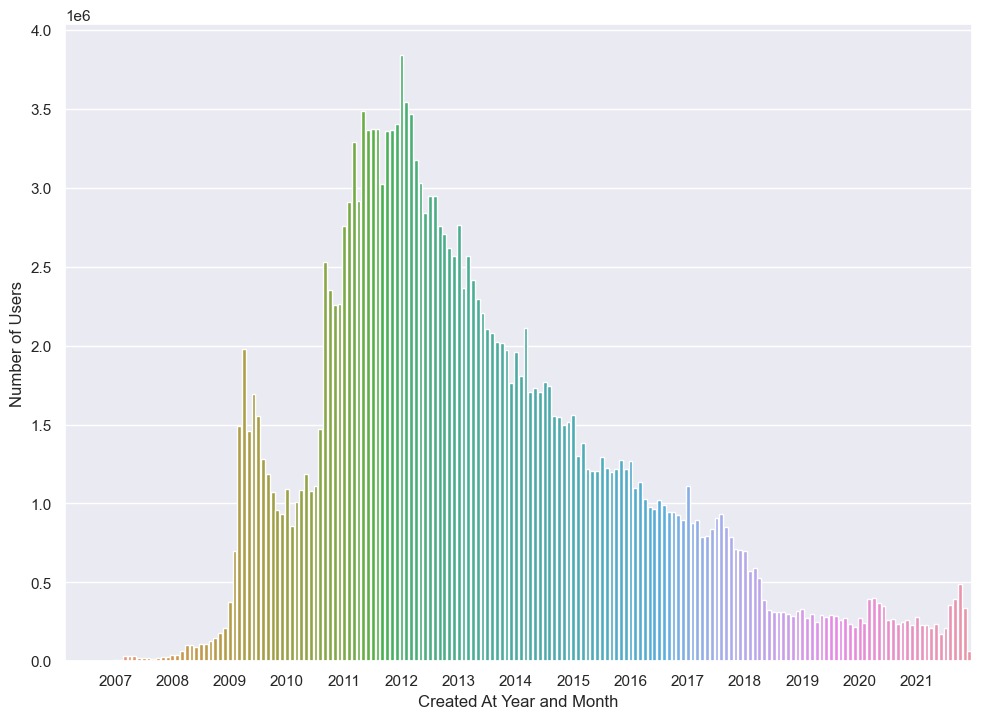

In [8]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
_, ax = plt.subplots()

sns.barplot(
    data=creation_time_stats_by_year_and_month.to_pandas(),
    x="Created At Year and Month",
    y="Number of Users",
)
xticklabels = [
    str(x)[:-2] if str(x)[-2:] == "01" else ""
    for x in creation_time_stats_by_year_and_month.get_column(
        "Created At Year and Month"
    )
]
_ = ax.set_xticklabels(xticklabels)

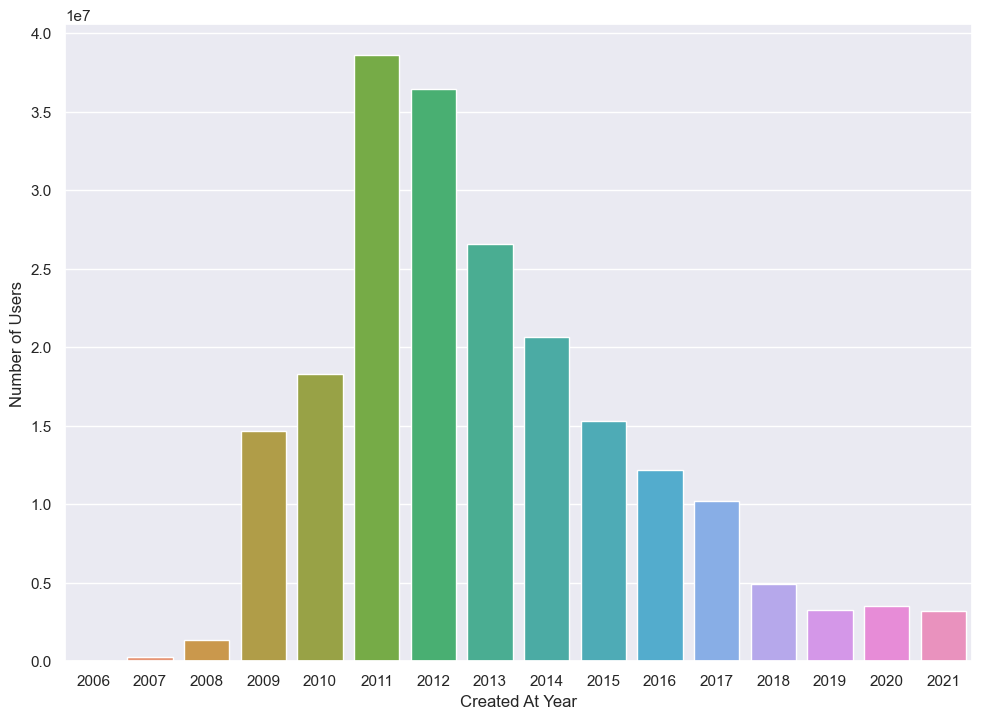

In [9]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
_ = sns.barplot(
    data=creation_time_stats_by_year.to_pandas(),
    x="Created At Year",
    y="Number of Users",
)